Daniel Lee

August 9th, 5PM

MiQ Technical Assessment

# LIBRARIES AND DATA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode
from matplotlib.ticker import FuncFormatter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter
from itertools import combinations

In [2]:
from google.colab import drive
drive.mount("/content/drive")

df = pd.read_csv("/content/drive/MyDrive/MiQ_Data/miq_raw_data.csv")
columns_df = pd.read_csv("/content/drive/MyDrive/MiQ_Data/columns.csv")

Mounted at /content/drive


<ipython-input-2-297c26b9a07f>:6: DtypeWarning: Columns (4,12,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/MiQ_Data/miq_raw_data.csv")


# EDA & DATA PREPROCESSING

In [3]:
# EDA 1
df.describe()

,timestamp,u1,u2,u5,u6,u7,u8,u9,u10,u11,u12,u13,u14,u15,u16,u17
count,117149,117149,117149,117149,117149,114408,117149,117149,27154,116329,107395,51203,117149,117149,117149,117149
unique,24666,1,68994,74332,5,3,5,403,6645,7398,9,12869,100520,3,117035,24949
top,10/5/17 10:34,undefined,Arizona,BI090SH74FBL,0,female,cc@braintree,1,SPRING,Sydney,NSW,undefined,undefined,AU,undefined,0
freq,27,117149,764,330,65022,97188,56018,60599,8884,3432,50928,25,25,110426,25,2012


In [4]:
# data preprocessing 1

# reformat to shift over
columns_df = columns_df.drop(columns=['Unnamed: 0'])
columns_df.columns = columns_df.iloc[0]
columns_df = columns_df[1:]
columns_df.reset_index(drop=True, inplace=True)

# map column name to u value
column_mapping = dict(zip(columns_df['U column'], columns_df['Column Type']))

# rename column names in df using dict
df.rename(columns=column_mapping, inplace=True)

# u1: Product_Subcategory: Subcategory of purchased product.
# u2: Product_Name: Name of purchased product.
# u5: Product_ID: ID for each product.
# u6: Is_First_Order: Indicates if purchase is customer's first order.
# u7: User_Gender: Gender of customer.
# u8: Payment_Type: Method of payment used for purchase.
# u9: Number_of_Products: Number of products in the order.
# u10: Order_Coupon_Code: Coupon code used for the order.
# u11: City: City where the customer is located.
# u12: Country_Province: Country or province of the customer.
# u13: User_Birthday: Birth date of the customer.
# u14: User_ID: Unique identifier for each customer.
# u15: Country_Code: ISO country code of the customer's location.
# u16: Order_ID: ID for each order.
# u17: Revenue(AUD): Revenue generated from the order in AUD.

In [5]:
# EDA 2

print(df.isnull().sum())
# u7 (gender) only missing 2.4% of rows - acceptable
# u10 (coupon code) missing 78.9% but acceptable given context that most customers probably don't have coupons
# u11 (city) only missing. 0.7% of rows - acceptable
# u12 (country providence) missing 8.5% - not ideal but not incredibly high
# u13 (birthday) missing 57.8% but acceptable given context, not directly correlated to sales data

timestamp                  0
Product_Subcategory        0
Product_Name               0
Product_ID                 0
Is_First_Order             0
User_Gender             2741
Payment_Type               0
Number_of_Products         0
Order_Coupon_Code      89995
City                     820
Country_Province        9754
User_Birthday          65946
User_ID                    0
Country_Code               0
Order_ID                   0
Revenue(AUD)               0
dtype: int64


In [6]:
# data preprocessing 2

# dropping rows with missing values for u7 (gender), u11 (city), u12 (country providence) gives us 89.5% of the raw data
df_first_clean = df.dropna(subset=['User_Gender', 'City', 'Country_Province'])

print(f"Rows before dropping nulls: {len(df)}")
print(f"Rows after dropping nulls: {len(df_first_clean)}")

Rows before dropping nulls: 117149
Rows after dropping nulls: 104790


In [7]:
# EDA 3

for column in df_first_clean.columns:
    print(f"Unique values and counts for {column}:")
    print(df_first_clean[column].value_counts())
    print("\n")

# every single column has 25 instances of 'undefined' likely that 25 rows have 'undefined' for every column, maybe website error or db error
# u1 (product subcategory) is 'undefined' for all rows - can discard

# we also see u6 (first order) has 4 distinct values of 2 0s and 2 1s, when there should only be 0 and 1

Unique values and counts for timestamp:
timestamp
10/5/17 10:34     25
10/4/17 10:28     24
10/4/17 10:00     24
10/4/17 3:33      21
10/4/17 10:49     21
                  ..
10/1/17 15:28      1
10/12/17 8:18      1
10/20/17 23:10     1
10/8/17 15:27      1
10/12/17 13:16     1
Name: count, Length: 24046, dtype: int64


Unique values and counts for Product_Subcategory:
Product_Subcategory
undefined    104790
Name: count, dtype: int64


Unique values and counts for Product_Name:
Product_Name
Arizona                                                                                                                                               732
Old Skool                                                                                                                                             353
Original SWS                                                                                                                                          347
Women's Tubular Shadow                  

In [8]:
# data preprocessing 3

# find and drop rows with 'undefined' for every column - problem rows, doesn't offer antyhing
undefined_rows = df_first_clean[(df_first_clean['Product_Name'] == "undefined") & (df_first_clean['Product_ID'] == "undefined")]
undefined_indices = undefined_rows.index
print("Indices of rows with 'undefined' for all columns:", undefined_indices)
print(f"Rows before dropping undefined: {len(df_first_clean)}")
df_second_clean = df_first_clean.drop(undefined_indices)
print(f"Rows after dropping undefined: {len(df_second_clean)}")

# drop u1 (product subcategory), all undefined
df_second_clean = df_second_clean.drop(columns=['Product_Subcategory'])

# normalize first order values so that there is only one of each value
df_second_clean['Is_First_Order'] = df_second_clean['Is_First_Order'].astype(str).str.strip()
df_second_clean['Is_First_Order'] = df_second_clean['Is_First_Order'].astype(int)
print(df_second_clean['Is_First_Order'].value_counts())

Indices of rows with 'undefined' for all columns: Index([ 35617,  37889,  38386,  41015,  41505,  44305,  51784,  54213,  54461,
        55239,  61156,  62534,  69169,  73671,  73767,  80587,  82413,  82923,
        83165,  90824,  92022,  94070,  94625, 105266, 110189],
      dtype='int64')
Rows before dropping undefined: 104790
Rows after dropping undefined: 104765
Is_First_Order
0    80365
1    24400
Name: count, dtype: int64


Number of entries in each revenue bucket:
Revenue_Bucket
0-499        102709
500-999        1776
1000-1499       190
1500-1999        61
2000-2499        18
2500-2999         1
3000-3499         3
3500-3999         4
4000-4499         2
4500-4999         0
5000+             1
Name: count, dtype: int64


<ipython-input-9-521b02c4b8d1>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bucket_counts.index, y=bucket_counts.values, palette="viridis")


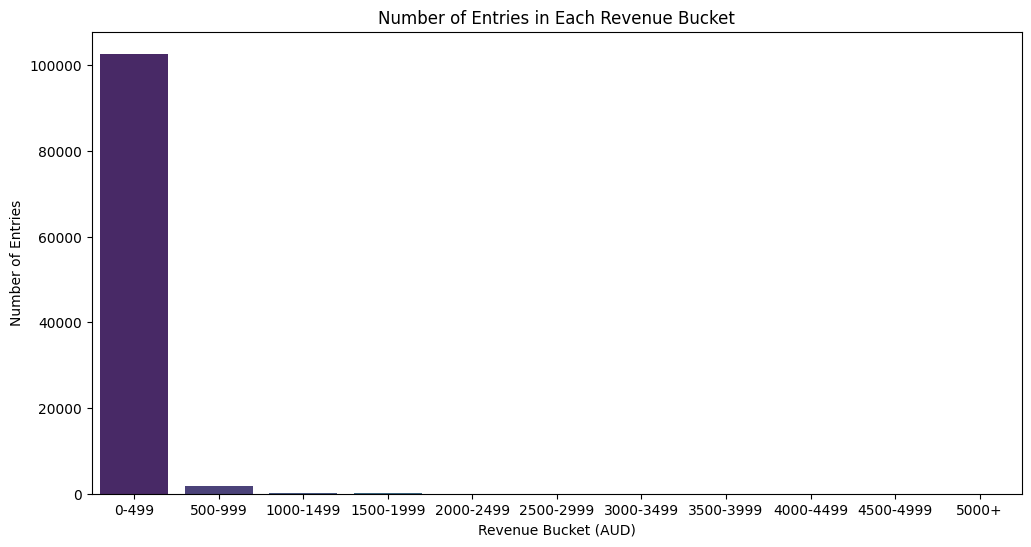

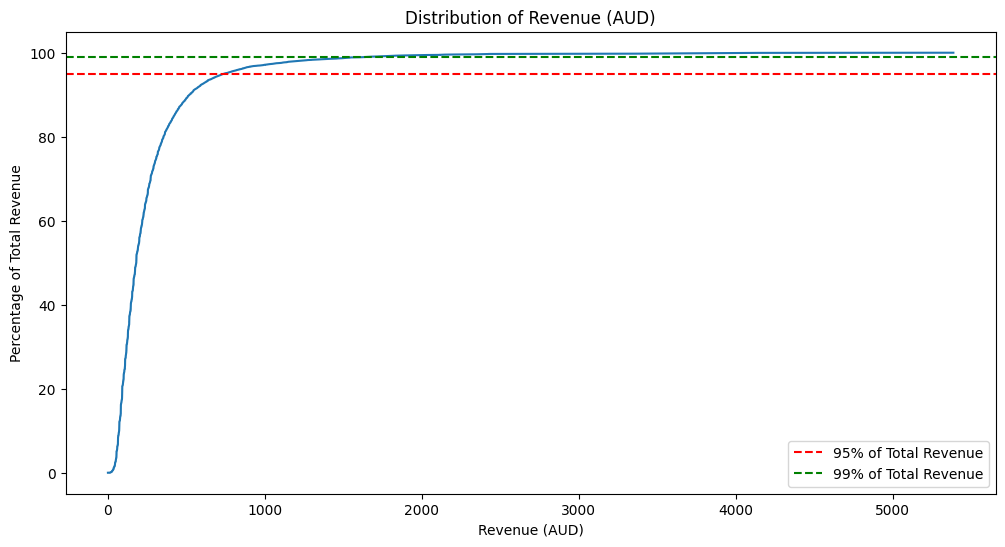

Threshold for 95% of total revenue: 740.37 AUD
Threshold for 99% of total revenue: 1644.01 AUD


In [9]:
# EDA 4

# convert datatypes
df_second_clean['Revenue(AUD)'] = pd.to_numeric(df_second_clean['Revenue(AUD)'], errors='coerce')

# categorize revenue values by unit of 500s
bins = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, float('inf')]
labels = ['0-499', '500-999', '1000-1499', '1500-1999', '2000-2499', '2500-2999', '3000-3499', '3500-3999', '4000-4499', '4500-4999', '5000+']
df_second_clean['Revenue_Bucket'] = pd.cut(df_second_clean['Revenue(AUD)'], bins=bins, labels=labels, right=False)

# count of customers in each bracket
bucket_counts = df_second_clean['Revenue_Bucket'].value_counts().sort_index()
print("Number of entries in each revenue bucket:")
print(bucket_counts)

plt.figure(figsize=(12, 6))
sns.barplot(x=bucket_counts.index, y=bucket_counts.values, palette="viridis")
plt.title('Number of Entries in Each Revenue Bucket')
plt.xlabel('Revenue Bucket (AUD)')
plt.ylabel('Number of Entries')
plt.show()

# EDA 4 cont.

# sort df by revenue
df_second_clean = df_second_clean.sort_values(by='Revenue(AUD)')

# calculate cumulative revenue and percentage of total revenue
df_second_clean['Cumulative_Revenue'] = df_second_clean['Revenue(AUD)'].cumsum()
total_revenue = df_second_clean['Revenue(AUD)'].sum()
df_second_clean['Cumulative_Percentage'] = (df_second_clean['Cumulative_Revenue'] / total_revenue) * 100

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_second_clean, x='Revenue(AUD)', y='Cumulative_Percentage')
plt.axhline(95, color='r', linestyle='--', label='95% of Total Revenue')
plt.axhline(99, color='g', linestyle='--', label='99% of Total Revenue')
plt.title('Distribution of Revenue (AUD)')
plt.xlabel('Revenue (AUD)')
plt.ylabel('Percentage of Total Revenue')
plt.legend()
plt.show()

# revenue threshold values for 95th and 99th percentile
revenue_95 = df_second_clean[df_second_clean['Cumulative_Percentage'] >= 95].iloc[0]['Revenue(AUD)']
revenue_99 = df_second_clean[df_second_clean['Cumulative_Percentage'] >= 99].iloc[0]['Revenue(AUD)']
print(f"Threshold for 95% of total revenue: {revenue_95:.2f} AUD")
print(f"Threshold for 99% of total revenue: {revenue_99:.2f} AUD")

In [10]:
# data processing 4

# reset index to make sure it's aligned
temp = df_second_clean.reset_index(drop=True)

# remove rows where revenue of customer is under the 99th percentile: 1644.01 AUD
temp2 = temp[(temp['Revenue(AUD)'] <= revenue_99) & (temp['Revenue(AUD)'] > 0)]
print(f"Original number of rows: {len(df_second_clean)}")
print(f"Number of rows after filtering: {len(temp2)}")

# drop temp rows from earlier to do calcs (short for calculator)
df_final = temp2.drop(columns=['Revenue_Bucket', 'Cumulative_Revenue', 'Cumulative_Percentage'])

# drop duplicate orders - form on the website must submit twice when the same exact order is made within a certain timeframe
df_final = df_final.drop_duplicates(subset=['Order_ID'])
print(f"Number of rows after removing duplicates: {len(df_final)}")
total_sales = df_final['Order_ID'].nunique()
print(f"Total Sales: {total_sales}")
df_final = df_final.reset_index(drop=True)

# dropped 63 customers that are high end outliers -> over 1644.01 AUD
# dropped 2170 customers that are low end outliers -> 0 AUD
# also noticed these 2170 customers had 'NoPayment' for their payment type -> did the other go through? site error? not sure - but decided to exclude
# another 72 customers with duplicate order #s
# 87.5% of raw data (customers) - however, 99% of total revenue

Original number of rows: 104765
Number of rows after filtering: 102532
Number of rows after removing duplicates: 102460
Total Sales: 102460


            timestamp Product_Name    Product_ID  Is_First_Order User_Gender  \
count          102460       102460        102460   102460.000000      102460   
unique          23982        61953         66675             NaN           2   
top     10/5/17 10:34      Arizona  BI090SH74FBL             NaN      female   
freq               25          721           315             NaN       87324   
mean              NaN          NaN           NaN        0.237498         NaN   
std               NaN          NaN           NaN        0.425552         NaN   
min               NaN          NaN           NaN        0.000000         NaN   
25%               NaN          NaN           NaN        0.000000         NaN   
50%               NaN          NaN           NaN        0.000000         NaN   
75%               NaN          NaN           NaN        0.000000         NaN   
max               NaN          NaN           NaN        1.000000         NaN   

        Payment_Type Number_of_Products

<ipython-input-11-0de1b71ea245>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bucket_counts.index, y=bucket_counts.values, palette="viridis")


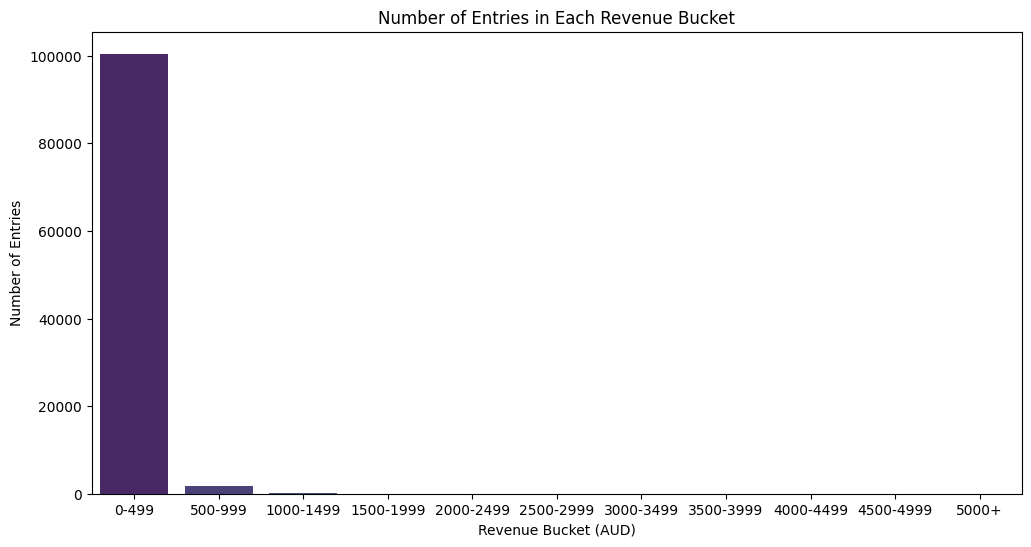

In [11]:
# confirm changes on cleaned data

print(df_final.describe(include='all'))

print(df_final.isnull().sum())

for column in df_final.columns:
    print(f"Unique values and counts for {column}:")
    print(df_final[column].value_counts())
    print("\n")

bins = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, float('inf')]
labels = ['0-499', '500-999', '1000-1499', '1500-1999', '2000-2499', '2500-2999', '3000-3499', '3500-3999', '4000-4499', '4500-4999', '5000+']
df_final['Revenue_Bucket'] = pd.cut(df_final['Revenue(AUD)'], bins=bins, labels=labels, right=False)

# count of customers in each bracket
bucket_counts = df_final['Revenue_Bucket'].value_counts().sort_index()
print("Number of entries in each revenue bucket:")
print(bucket_counts)

plt.figure(figsize=(12, 6))
sns.barplot(x=bucket_counts.index, y=bucket_counts.values, palette="viridis")
plt.title('Number of Entries in Each Revenue Bucket')
plt.xlabel('Revenue Bucket (AUD)')
plt.ylabel('Number of Entries')
plt.show()

# SALES OVERVIEW

In [12]:
# Overall: Summarize the total sales and revenue for the given time period

total_sales = df_final['Order_ID'].nunique()
total_revenue = df_final['Revenue(AUD)'].sum()

print(f'Total Sales: {total_sales}')
print(f'Total Revenue: ${total_revenue:.2f}')

Total Sales: 102460
Total Revenue: $14136350.70


In [13]:
# Basket: Analyze the average unique quantity and revenue per order

# udfs to calculate total number of products and unique products in each order
def calculate_total_products(number_of_products):
    quantities = [int(qty) for qty in number_of_products.split(',')]
    return sum(quantities)
def calculate_unique_products(number_of_products):
    return len(number_of_products.split(','))

# create new columns using udfs
df_final['Unique_Products'] = df_final['Number_of_Products'].apply(calculate_unique_products)
df_final['Total_Products'] = df_final['Number_of_Products'].apply(calculate_total_products)

average_unique_quantity_per_order = df_final['Unique_Products'].mean()
average_revenue_per_order = df_final.groupby('Order_ID')['Revenue(AUD)'].sum().mean()
average_quantity_per_order = df_final['Total_Products'].mean()

print(f'Average Quantity per Order: {average_quantity_per_order:.2f}')
print(f'Average Unique Quantity per Order: {average_unique_quantity_per_order:.2f}')
print(f'Average Revenue per Order: ${average_revenue_per_order:.2f}')

Average Quantity per Order: 2.03
Average Unique Quantity per Order: 1.98
Average Revenue per Order: $137.97


<ipython-input-14-e83f7988ee78>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_final['timestamp'] = pd.to_datetime(df_final['timestamp'])


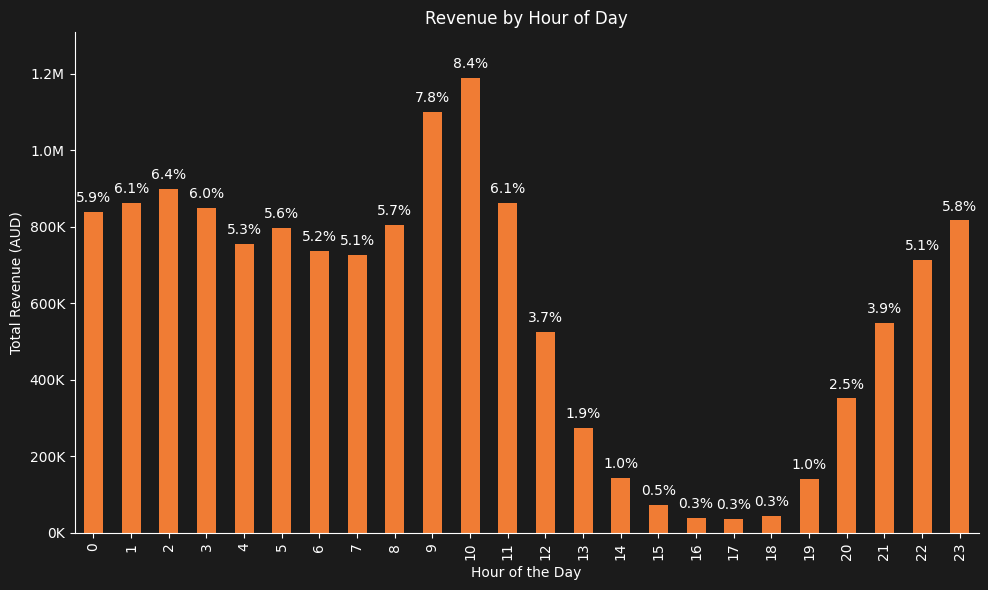

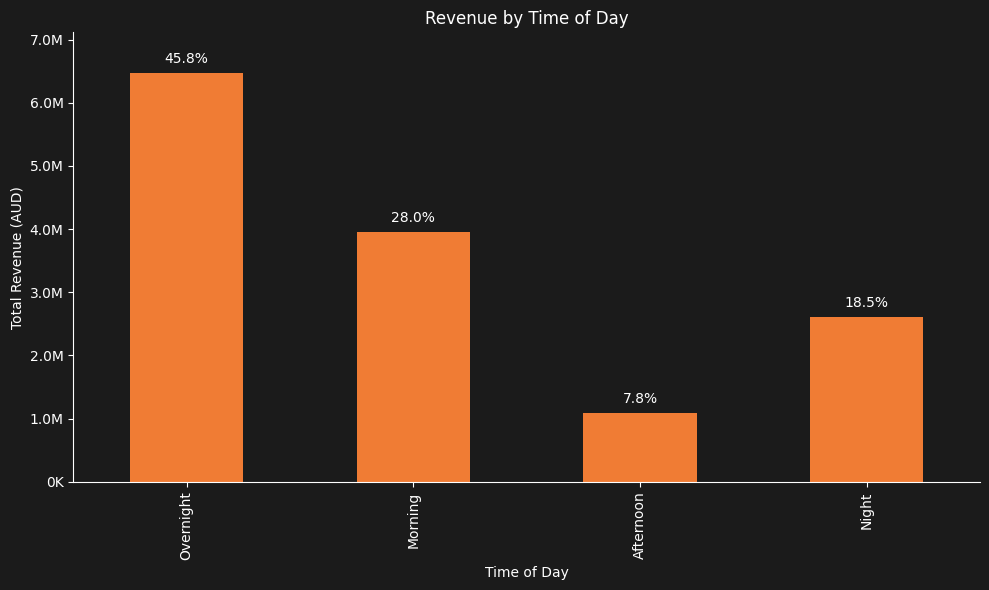

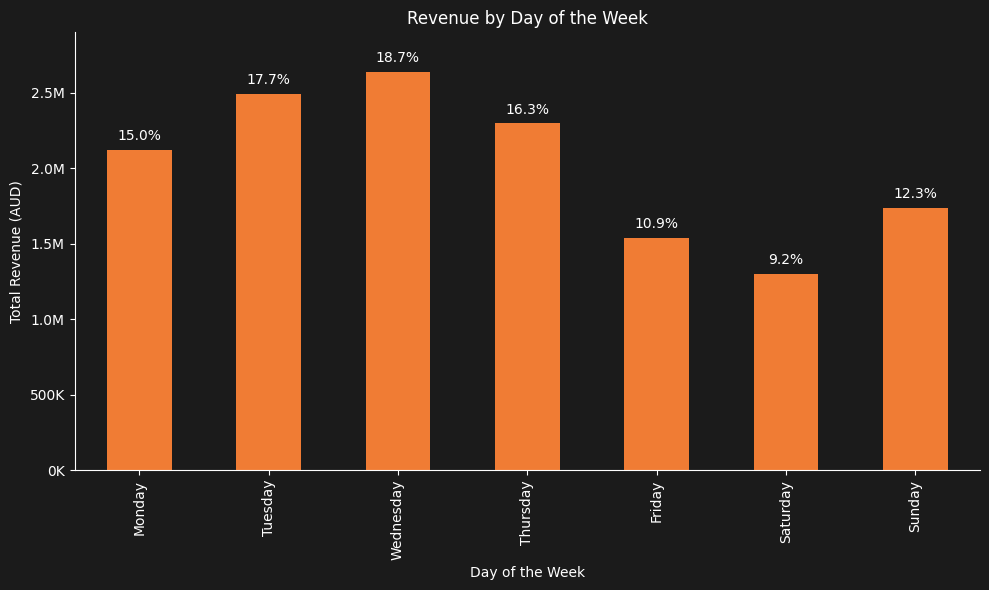

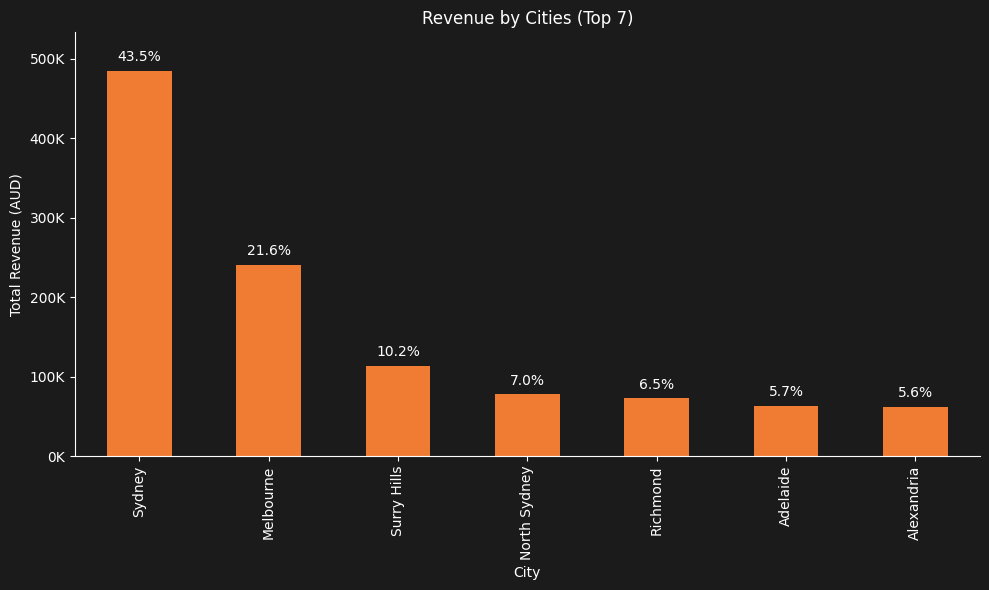

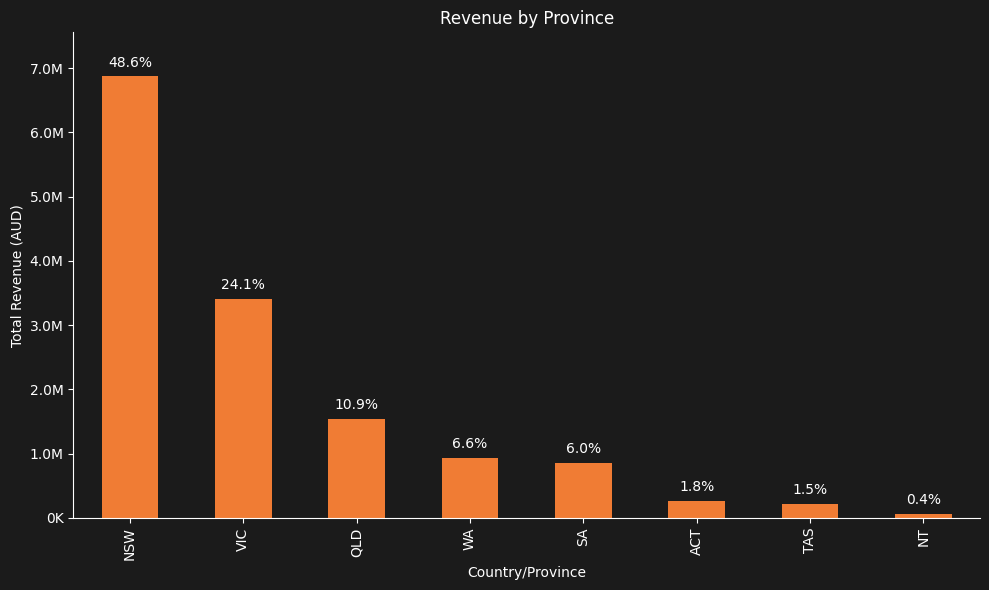

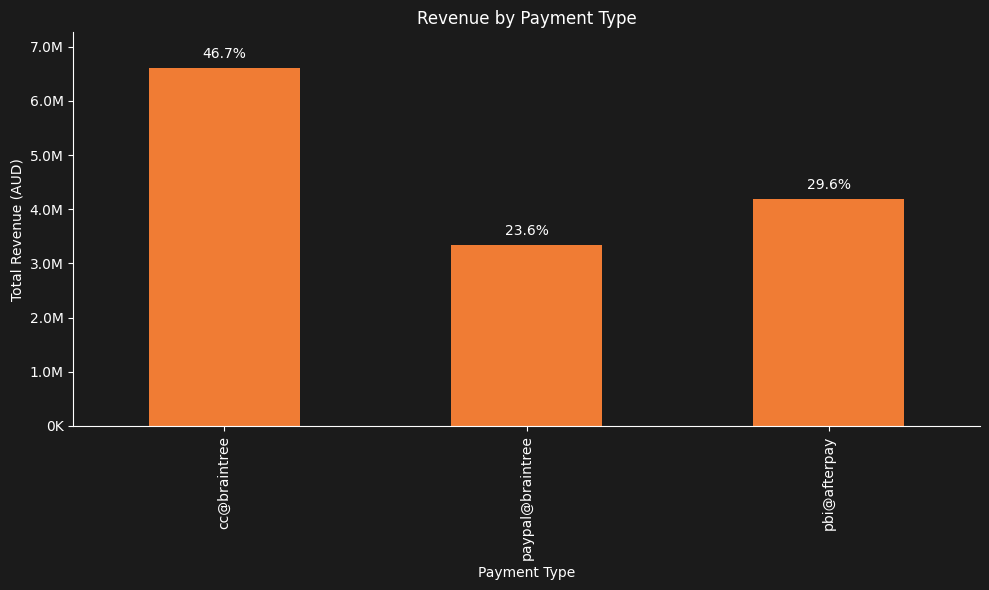

In [14]:
# Attributes: Break down sales by time of day, day of the week, geography, and payment type

# reformat timestamp to datetime format
df_final['timestamp'] = pd.to_datetime(df_final['timestamp'])

# create hour and day columns
df_final['hour'] = df_final['timestamp'].dt.hour
df_final['day_of_week'] = df_final['timestamp'].dt.day_name()

# fixing day of week ordering
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_final['day_of_week'] = pd.Categorical(df_final['day_of_week'], categories=days_order, ordered=True)

# fixing time of day ordering
df_final['time_of_day'] = df_final['hour'].apply(categorize_hour)
time_of_day_revenue = df_final.groupby('time_of_day')['Revenue(AUD)'].sum()
time_of_day_revenue = time_of_day_revenue.reindex(['Overnight', 'Morning', 'Afternoon', 'Night'])

# udf to categorize hours into time of day
def categorize_hour(hour):
    if 0 <= hour < 8:
        return 'Overnight'
    elif 8 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Night'

# udf to format thousands and millions on y axis for readability
def thousands_and_millions(x, pos):
    if x >= 1e6:
        return '%1.1fM' % (x * 1e-6)
    else:
        return '%1.0fK' % (x * 1e-3)
formatter = FuncFormatter(thousands_and_millions)

# udf to annotte percentages of each bar on plots
def annotate_percentages(ax, data):
    total = data.sum()
    for p in ax.patches:
        percentage = (p.get_height() / total) * 100
        ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='#ffffff')

# hour of day
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#1b1b1b')
ax.set_facecolor('#1b1b1b')
ax.spines['bottom'].set_color('#ffffff')
ax.spines['left'].set_color('#ffffff')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(axis='x', colors='#ffffff')
ax.tick_params(axis='y', colors='#ffffff')
ax.yaxis.label.set_color('#ffffff')
ax.xaxis.label.set_color('#ffffff')
ax.title.set_color('#ffffff')
hourly_revenue = df_final.groupby('hour')['Revenue(AUD)'].sum()
hourly_revenue.plot(kind='bar', ax=ax, title='Revenue by Hour of Day', color='#f07c34')
ax.set_ylim(0, max(hourly_revenue) * 1.1)
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Total Revenue (AUD)')
ax.yaxis.set_major_formatter(formatter)
annotate_percentages(ax, hourly_revenue)
plt.tight_layout()
plt.savefig('hour of day.png', format='png', dpi=300, bbox_inches='tight')
plt.show()
print()

# time of day (categories)
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#1b1b1b')
ax.set_facecolor('#1b1b1b')
ax.spines['bottom'].set_color('#ffffff')
ax.spines['left'].set_color('#ffffff')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(axis='x', colors='#ffffff')
ax.tick_params(axis='y', colors='#ffffff')
ax.yaxis.label.set_color('#ffffff')
ax.xaxis.label.set_color('#ffffff')
ax.title.set_color('#ffffff')
time_of_day_revenue.plot(kind='bar', ax=ax, title='Revenue by Time of Day', color='#f07c34')
ax.set_ylim(0, max(time_of_day_revenue) * 1.1)
ax.set_xlabel('Time of Day')
ax.set_ylabel('Total Revenue (AUD)')
ax.yaxis.set_major_formatter(formatter)
annotate_percentages(ax, time_of_day_revenue)
plt.tight_layout()
plt.savefig('time of day.png', format='png', dpi=300, bbox_inches='tight')
plt.show()
print()

# day of week
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#1b1b1b')
ax.set_facecolor('#1b1b1b')
ax.spines['bottom'].set_color('#ffffff')
ax.spines['left'].set_color('#ffffff')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(axis='x', colors='#ffffff')
ax.tick_params(axis='y', colors='#ffffff')
ax.yaxis.label.set_color('#ffffff')
ax.xaxis.label.set_color('#ffffff')
ax.title.set_color('#ffffff')
day_of_week_revenue = df_final.groupby('day_of_week', observed=True)['Revenue(AUD)'].sum()
day_of_week_revenue.plot(kind='bar', ax=ax, title='Revenue by Day of the Week', color='#f07c34')
ax.set_ylim(0, max(day_of_week_revenue) * 1.1)
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Total Revenue (AUD)')
ax.yaxis.set_major_formatter(formatter)
annotate_percentages(ax, day_of_week_revenue)
plt.tight_layout()
plt.savefig('day of week.png', format='png', dpi=300, bbox_inches='tight')
plt.show()
print()

# geography - city
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#1b1b1b')
ax.set_facecolor('#1b1b1b')
ax.spines['bottom'].set_color('#ffffff')
ax.spines['left'].set_color('#ffffff')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(axis='x', colors='#ffffff')
ax.tick_params(axis='y', colors='#ffffff')
ax.yaxis.label.set_color('#ffffff')
ax.xaxis.label.set_color('#ffffff')
ax.title.set_color('#ffffff')
city_revenue = df_final.groupby('City')['Revenue(AUD)'].sum().nlargest(7)
city_revenue.plot(kind='bar', ax=ax, title='Revenue by Cities (Top 7)', color='#f07c34')
ax.set_ylim(0, max(city_revenue) * 1.1)
ax.set_xlabel('City')
ax.set_ylabel('Total Revenue (AUD)')
ax.yaxis.set_major_formatter(formatter)
annotate_percentages(ax, city_revenue)
plt.tight_layout()
plt.savefig('city.png', format='png', dpi=300, bbox_inches='tight')
plt.show()
print()

# geography - province
geography_revenue = df_final.groupby('Country_Province')['Revenue(AUD)'].sum().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#1b1b1b')
ax.set_facecolor('#1b1b1b')
ax.spines['bottom'].set_color('#ffffff')
ax.spines['left'].set_color('#ffffff')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(axis='x', colors='#ffffff')
ax.tick_params(axis='y', colors='#ffffff')
ax.yaxis.label.set_color('#ffffff')
ax.xaxis.label.set_color('#ffffff')
ax.title.set_color('#ffffff')
geography_revenue.plot(kind='bar', ax=ax, title='Revenue by Province', color='#f07c34')
ax.set_ylim(0, max(geography_revenue) * 1.1)
ax.set_xlabel('Country/Province')
ax.set_ylabel('Total Revenue (AUD)')
ax.yaxis.set_major_formatter(formatter)
annotate_percentages(ax, geography_revenue)
plt.tight_layout()
plt.savefig('province.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


# payment type
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#1b1b1b')
ax.set_facecolor('#1b1b1b')
ax.spines['bottom'].set_color('#ffffff')
ax.spines['left'].set_color('#ffffff')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(axis='x', colors='#ffffff')
ax.tick_params(axis='y', colors='#ffffff')
ax.yaxis.label.set_color('#ffffff')
ax.xaxis.label.set_color('#ffffff')
ax.title.set_color('#ffffff')
payment_type_revenue = df_final.groupby('Payment_Type')['Revenue(AUD)'].sum()
payment_type_revenue.plot(kind='bar', ax=ax, title='Revenue by Payment Type', color='#f07c34')
ax.set_ylim(0, max(payment_type_revenue) * 1.1)
ax.set_xlabel('Payment Type')
ax.set_ylabel('Total Revenue (AUD)')
ax.yaxis.set_major_formatter(formatter)
annotate_percentages(ax, payment_type_revenue)
plt.tight_layout()
plt.savefig('payment_type.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

# CUSTOMER FREQUENCY AND BEHAVIOR

In [15]:
# Determine the number of single vs. multiple buyers

purchase_frequency = df_final.groupby('User_ID')['Order_ID'].nunique()
single_buyers = (purchase_frequency == 1).sum()
frequent_buyers = (purchase_frequency > 1).sum()

purchases_by_frequent_buyers = df_final[df_final['User_ID'].isin(purchase_frequency[purchase_frequency > 1].index)]['Order_ID'].nunique()

print(f'Single Buyers: {single_buyers}')
print(f'Frequent Buyers: {frequent_buyers}')
print(f'Purchases Made by Frequent Buyers: {purchases_by_frequent_buyers}')

Single Buyers: 77280
Frequent Buyers: 10928
Purchases Made by Frequent Buyers: 25180


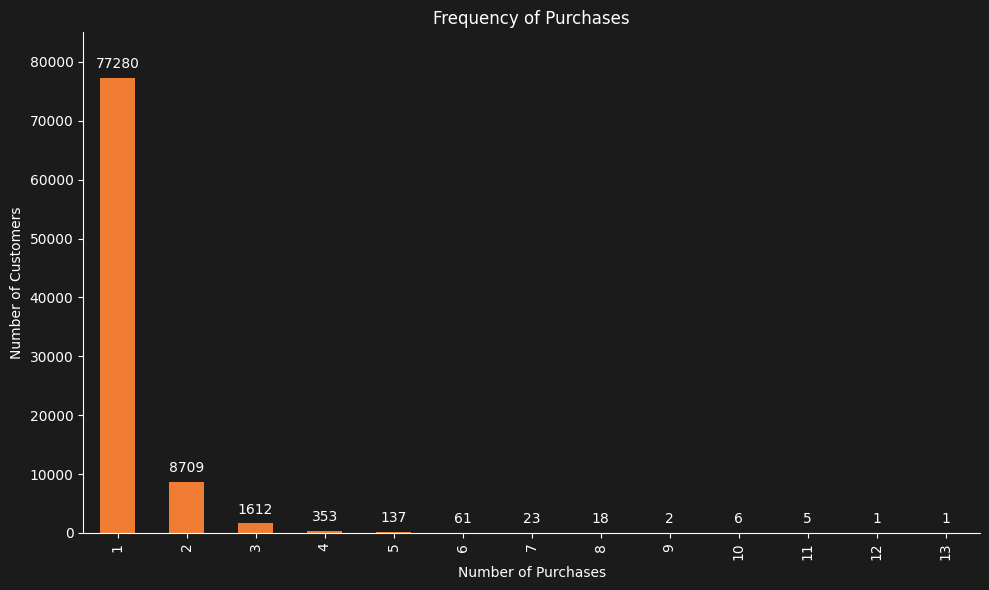

In [16]:
# Assess the frequency of multi-purchases

# plot multi purchase frequency (starting 2)
#multi_purchase_frequency = purchase_frequency[purchase_frequency > 1].value_counts().sort_index()
#fig, ax = plt.subplots()
#multi_purchase_frequency.plot(kind='bar', ax=ax)
#ax.set_ylim(0, max(multi_purchase_frequency) * 1.1)
#ax.set_xlabel('Number of Purchases')
#ax.set_ylabel('Number of Customers')
#ax.set_title('Frequency of Multi-Purchases')
#for p in ax.patches:
#    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
#plt.tight_layout()
#plt.show()

# plot purchase frequency (starting 1)
all_purchase_frequency = purchase_frequency.value_counts().sort_index()
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#1b1b1b')
ax.set_facecolor('#1b1b1b')
ax.spines['bottom'].set_color('#ffffff')
ax.spines['left'].set_color('#ffffff')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(axis='x', colors='#ffffff')
ax.tick_params(axis='y', colors='#ffffff')
ax.yaxis.label.set_color('#ffffff')
ax.xaxis.label.set_color('#ffffff')
ax.title.set_color('#ffffff')
all_purchase_frequency.plot(kind='bar', ax=ax, title='Frequency of Purchases', color='#f07c34')
ax.set_ylim(0, max(all_purchase_frequency) * 1.1)
ax.set_xlabel('Number of Purchases')
ax.set_ylabel('Number of Customers')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='#ffffff')
plt.tight_layout()
plt.savefig('purchase frequency.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

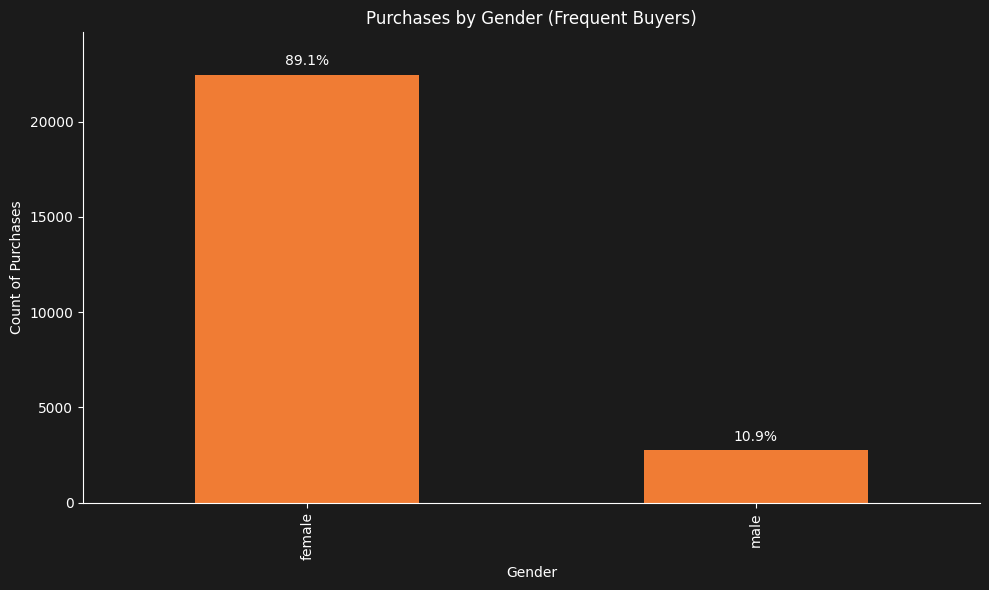

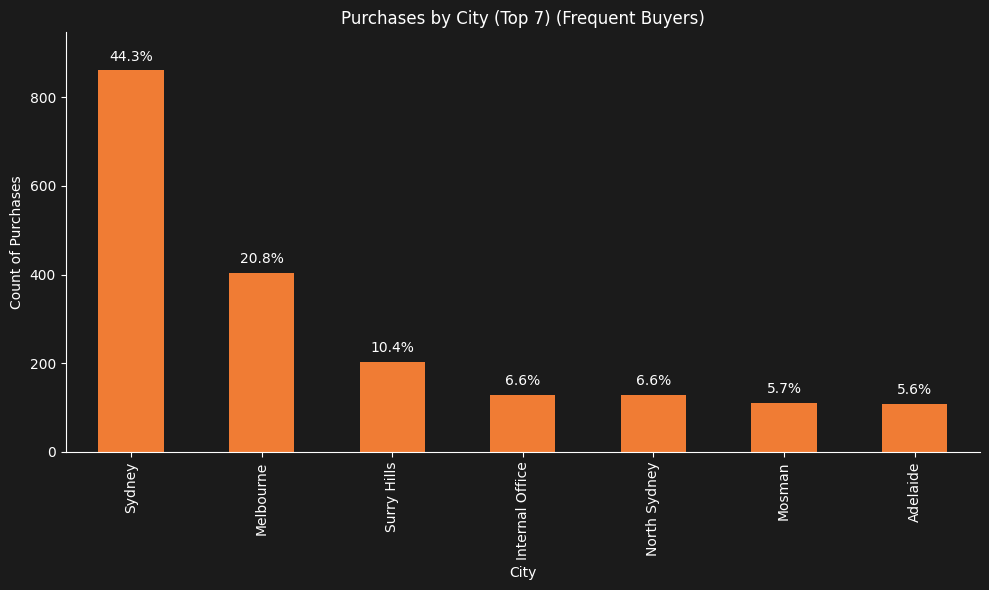

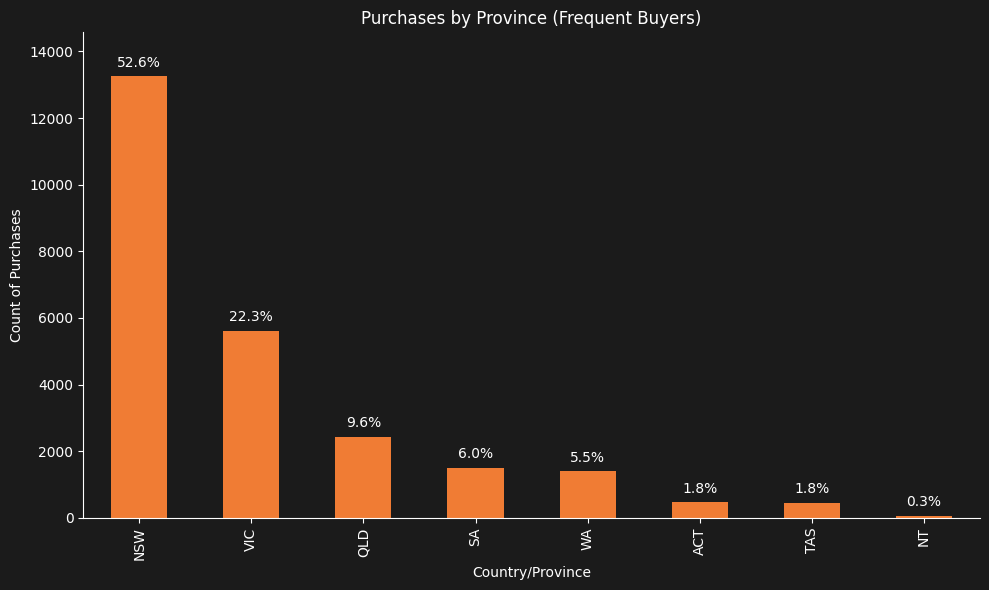

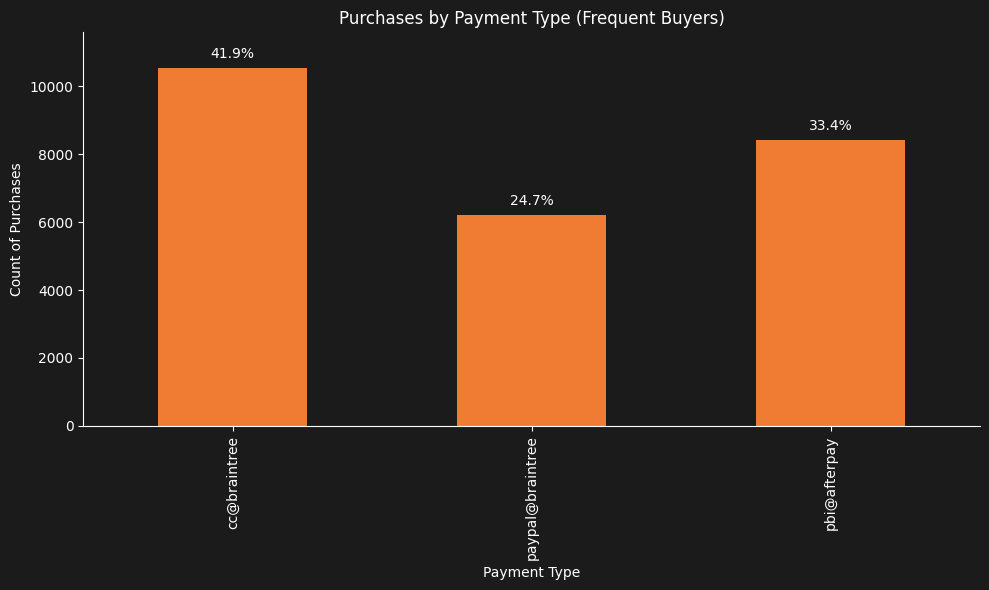

In [17]:
# Identify any common attributes among frequent buyers

# female frequent buyers / total frequent buyers

# filter out only frequent buyers
multiple_purchasers = purchase_frequency[purchase_frequency > 1].index
df_frequent = df_final[df_final['User_ID'].isin(multiple_purchasers)].copy()

# fixing time of day ordering
df_frequent.loc[:, 'time_of_day'] = df_frequent['hour'].apply(categorize_hour)

# gender - frequent buyers
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#1b1b1b')
ax.set_facecolor('#1b1b1b')
ax.spines['bottom'].set_color('#ffffff')
ax.spines['left'].set_color('#ffffff')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(axis='x', colors='#ffffff')
ax.tick_params(axis='y', colors='#ffffff')
ax.yaxis.label.set_color('#ffffff')
ax.xaxis.label.set_color('#ffffff')
ax.title.set_color('#ffffff')
gender_purchase_count = df_frequent.groupby('User_Gender')['Order_ID'].count()
gender_purchase_count.plot(kind='bar', ax=ax, title='Purchases by Gender (Frequent Buyers)', color='#f07c34')
ax.set_ylim(0, max(gender_purchase_count) * 1.1)
ax.set_xlabel('Gender')
ax.set_ylabel('Count of Purchases')
annotate_percentages(ax, gender_purchase_count)
plt.tight_layout()
plt.savefig('gender - fb.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

# city - frequent buyers
city_purchase_count = df_frequent.groupby('City')['Order_ID'].count().nlargest(7)
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#1b1b1b')
ax.set_facecolor('#1b1b1b')
ax.spines['bottom'].set_color('#ffffff')
ax.spines['left'].set_color('#ffffff')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(axis='x', colors='#ffffff')
ax.tick_params(axis='y', colors='#ffffff')
ax.yaxis.label.set_color('#ffffff')
ax.xaxis.label.set_color('#ffffff')
ax.title.set_color('#ffffff')
city_purchase_count.plot(kind='bar', ax=ax, title='Purchases by City (Top 7) (Frequent Buyers)', color='#f07c34')
ax.set_ylim(0, max(city_purchase_count) * 1.1)
ax.set_xlabel('City')
ax.set_ylabel('Count of Purchases')
annotate_percentages(ax, city_purchase_count)
plt.tight_layout()
plt.savefig('city - fb.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

# province - frequent buyers
geography_purchase_count = df_frequent.groupby('Country_Province')['Order_ID'].count().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#1b1b1b')
ax.set_facecolor('#1b1b1b')
ax.spines['bottom'].set_color('#ffffff')
ax.spines['left'].set_color('#ffffff')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(axis='x', colors='#ffffff')
ax.tick_params(axis='y', colors='#ffffff')
ax.yaxis.label.set_color('#ffffff')
ax.xaxis.label.set_color('#ffffff')
ax.title.set_color('#ffffff')
geography_purchase_count.plot(kind='bar', ax=ax, title='Purchases by Province (Frequent Buyers)', color='#f07c34')
ax.set_ylim(0, max(geography_purchase_count) * 1.1)
ax.set_xlabel('Country/Province')
ax.set_ylabel('Count of Purchases')
annotate_percentages(ax, geography_purchase_count)
plt.tight_layout()
plt.savefig('province - fb.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


# payment type - frequent buyers
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#1b1b1b')
ax.set_facecolor('#1b1b1b')
ax.spines['bottom'].set_color('#ffffff')
ax.spines['left'].set_color('#ffffff')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(axis='x', colors='#ffffff')
ax.tick_params(axis='y', colors='#ffffff')
ax.yaxis.label.set_color('#ffffff')
ax.xaxis.label.set_color('#ffffff')
ax.title.set_color('#ffffff')
payment_type_purchase_count = df_frequent.groupby('Payment_Type')['Order_ID'].count()
payment_type_purchase_count.plot(kind='bar', ax=ax, title='Purchases by Payment Type (Frequent Buyers)', color='#f07c34')
ax.set_ylim(0, max(payment_type_purchase_count) * 1.1)
ax.set_xlabel('Payment Type')
ax.set_ylabel('Count of Purchases')
annotate_percentages(ax, payment_type_purchase_count)
plt.tight_layout()
plt.savefig('payment - fb.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

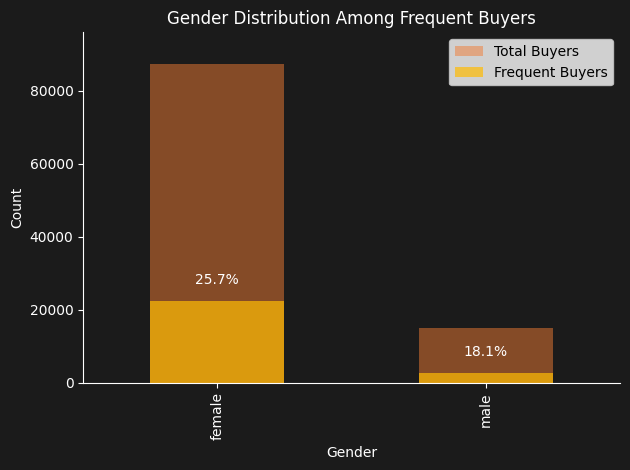

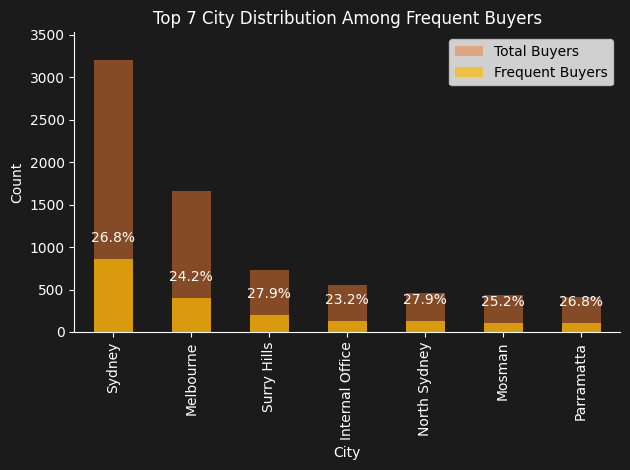

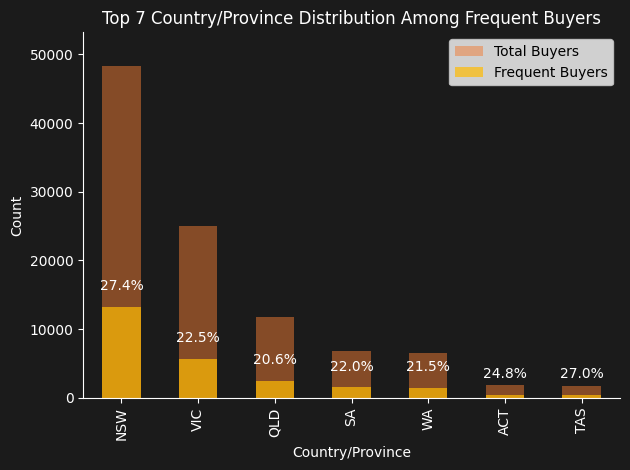

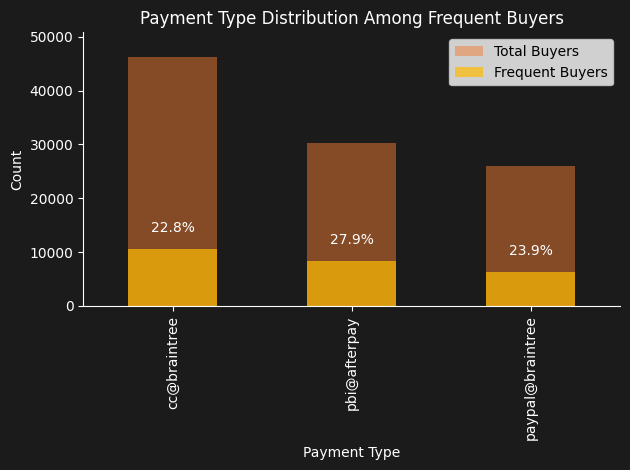

In [18]:
# female frequent buyers / female buyers

def calculate_percentage(subset, total):
    return (subset / total) * 100

# calc total counts
total_users = df_final['User_ID'].nunique()
total_orders = df_final['Order_ID'].nunique()

# calc counts and percentages for frequent buyers
gender_counts = df_frequent['User_Gender'].value_counts()
gender_percentages = gender_counts.apply(lambda x: calculate_percentage(x, total_users))
city_counts = df_frequent['City'].value_counts()
city_percentages = city_counts.apply(lambda x: calculate_percentage(x, total_users))
country_counts = df_frequent['Country_Province'].value_counts()
country_percentages = country_counts.apply(lambda x: calculate_percentage(x, total_users))
payment_counts = df_frequent['Payment_Type'].value_counts()
payment_percentages = payment_counts.apply(lambda x: calculate_percentage(x, total_users))

# counts for total buyers
total_gender_counts = df_final['User_Gender'].value_counts()
total_city_counts = df_final['City'].value_counts()
total_country_counts = df_final['Country_Province'].value_counts()
total_payment_counts = df_final['Payment_Type'].value_counts()

# udf to plot with overlay and percentages
def plot_with_overlay(total_counts, frequent_counts, title, xlabel):
    fig, ax = plt.subplots()
    fig.patch.set_facecolor('#1b1b1b')
    ax.set_facecolor('#1b1b1b')
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(axis='x', colors='#ffffff')
    ax.tick_params(axis='y', colors='#ffffff')
    ax.yaxis.label.set_color('#ffffff')
    ax.xaxis.label.set_color('#ffffff')
    ax.title.set_color('#ffffff')
    total_counts.plot(kind='bar', ax=ax, color='#f07c34', alpha=0.5, label='Total Buyers')
    frequent_counts.plot(kind='bar', ax=ax, color='#ffbc04', alpha=0.7, label='Frequent Buyers')
    ax.set_ylim(0, max(total_counts.max(), frequent_counts.max()) * 1.1)
    for i, p in enumerate(ax.patches[:len(total_counts)]):
        total_height = p.get_height()
        frequent_height = ax.patches[len(total_counts) + i].get_height()
        percentage = (frequent_height / total_height) * 100 if total_height > 0 else 0
        ax.annotate(f'{percentage:.1f}%',
                    (p.get_x() + p.get_width() / 2., frequent_height),
                    ha='center', va='bottom', xytext=(0, 10), textcoords='offset points', color='#ffffff')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()

# plot distributions
plot_with_overlay(total_gender_counts, gender_counts, 'Gender Distribution Among Frequent Buyers', 'Gender')
plot_with_overlay(total_city_counts.head(7), city_counts.head(7), 'Top 7 City Distribution Among Frequent Buyers', 'City')
plot_with_overlay(total_country_counts.head(7), country_counts.head(7), 'Top 7 Country/Province Distribution Among Frequent Buyers', 'Country/Province')
plot_with_overlay(total_payment_counts, payment_counts, 'Payment Type Distribution Among Frequent Buyers', 'Payment Type')

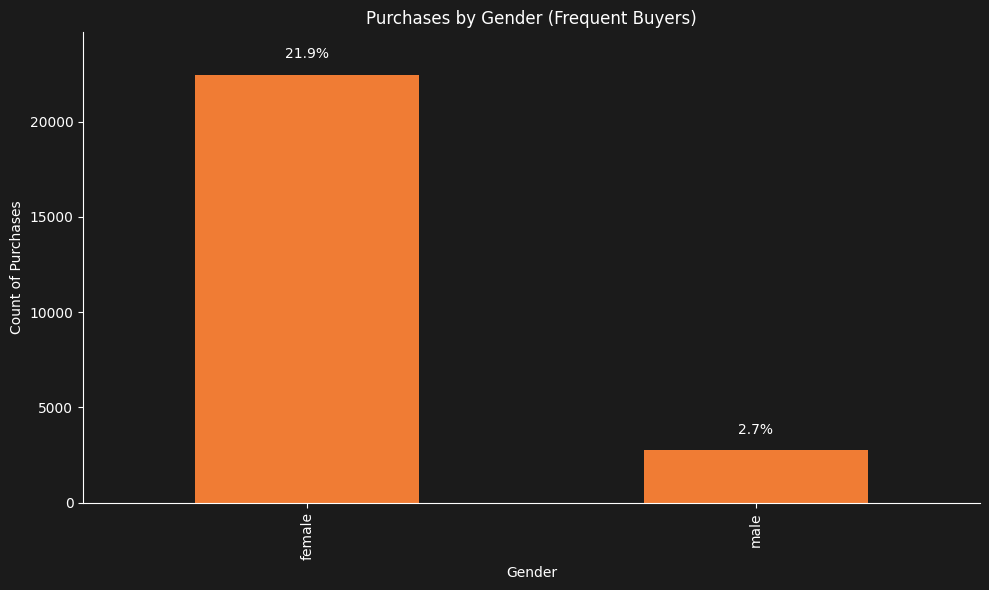

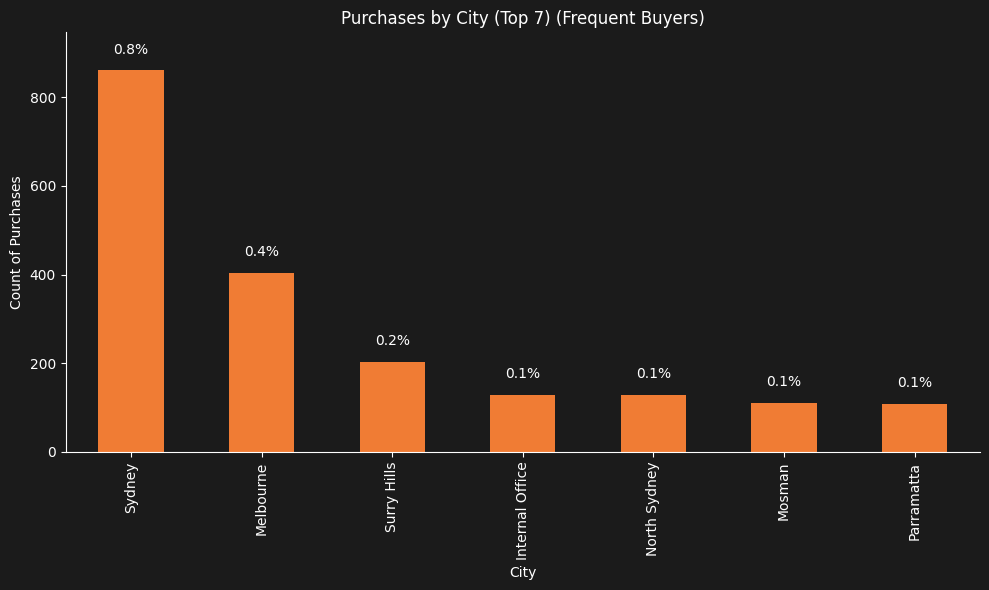

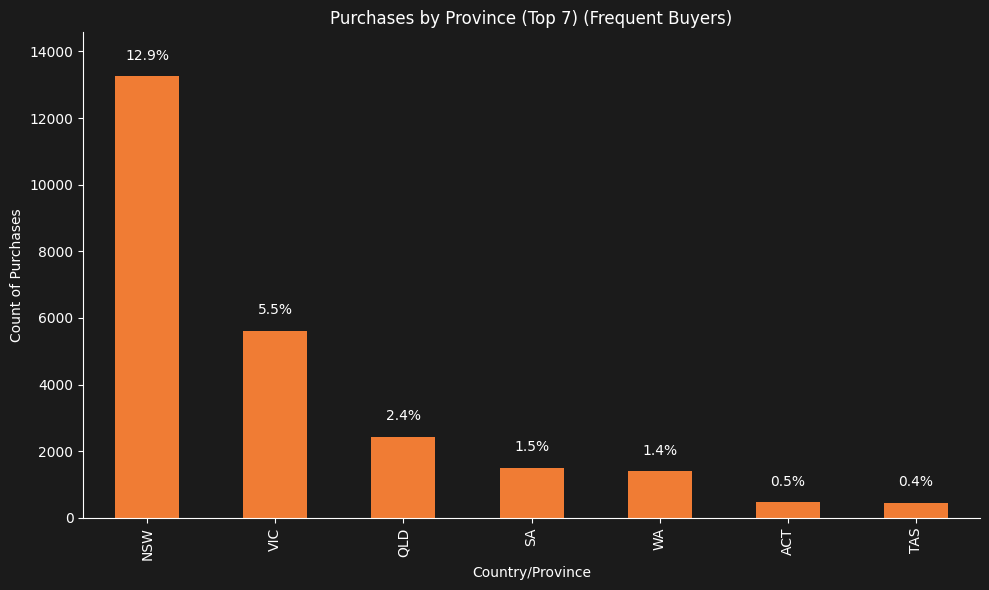

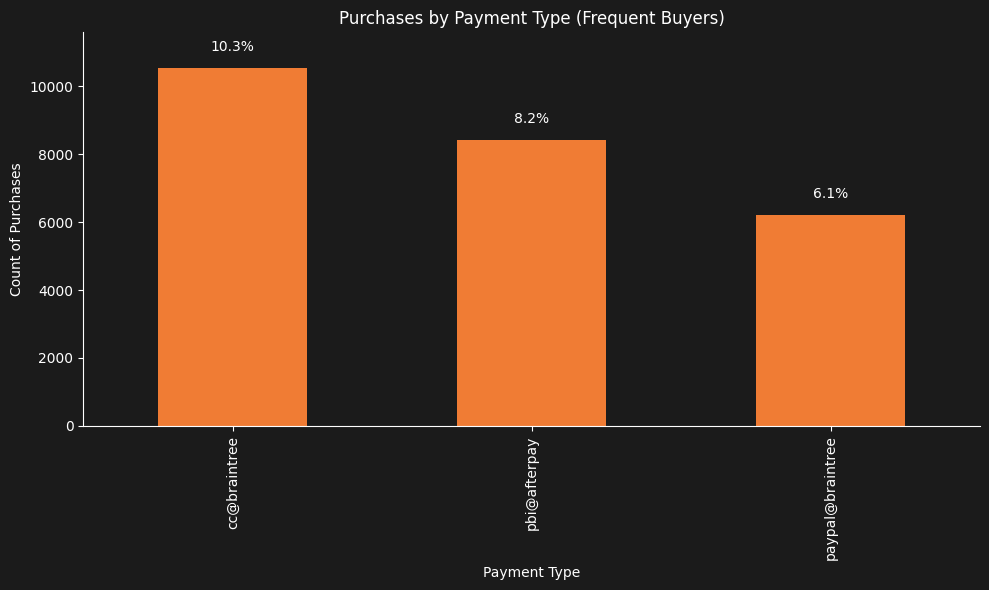

In [19]:
# female frequent orders / total orders

# calc counts for total orders
total_gender_counts = df_final['User_Gender'].value_counts()
total_city_counts = df_final['City'].value_counts()
total_country_counts = df_final['Country_Province'].value_counts()
total_payment_counts = df_final['Payment_Type'].value_counts()

def annotate_percentages_total(ax, data, total_sum):
    for p in ax.patches:
        percentage = (p.get_height() / total_sum) * 100
        ax.annotate(f'{percentage:.1f}%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', xytext=(0, 10), textcoords='offset points', color='#ffffff')

# gender
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#1b1b1b')
ax.set_facecolor('#1b1b1b')
ax.spines['bottom'].set_color('#ffffff')
ax.spines['left'].set_color('#ffffff')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(axis='x', colors='#ffffff')
ax.tick_params(axis='y', colors='#ffffff')
ax.yaxis.label.set_color('#ffffff')
ax.xaxis.label.set_color('#ffffff')
ax.title.set_color('#ffffff')
gender_purchase_count = gender_counts
gender_purchase_count.plot(kind='bar', ax=ax, title='Purchases by Gender (Frequent Buyers)', color='#f07c34')
ax.set_ylim(0, max(gender_purchase_count) * 1.1)
ax.set_xlabel('Gender')
ax.set_ylabel('Count of Purchases')
annotate_percentages_total(ax, gender_purchase_count, total_gender_counts.sum())
plt.tight_layout()
plt.show()

# cities (top 7)
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#1b1b1b')
ax.set_facecolor('#1b1b1b')
ax.spines['bottom'].set_color('#ffffff')
ax.spines['left'].set_color('#ffffff')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(axis='x', colors='#ffffff')
ax.tick_params(axis='y', colors='#ffffff')
ax.yaxis.label.set_color('#ffffff')
ax.xaxis.label.set_color('#ffffff')
ax.title.set_color('#ffffff')
city_purchase_count = city_counts.nlargest(7)
city_purchase_count.plot(kind='bar', ax=ax, title='Purchases by City (Top 7) (Frequent Buyers)', color='#f07c34')
ax.set_ylim(0, max(city_purchase_count) * 1.1)
ax.set_xlabel('City')
ax.set_ylabel('Count of Purchases')
annotate_percentages_total(ax, city_purchase_count, total_city_counts.sum())
plt.tight_layout()
plt.show()


# province (top 7)
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#1b1b1b')
ax.set_facecolor('#1b1b1b')
ax.spines['bottom'].set_color('#ffffff')
ax.spines['left'].set_color('#ffffff')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(axis='x', colors='#ffffff')
ax.tick_params(axis='y', colors='#ffffff')
ax.yaxis.label.set_color('#ffffff')
ax.xaxis.label.set_color('#ffffff')
ax.title.set_color('#ffffff')
country_purchase_count = country_counts.nlargest(7)
country_purchase_count.plot(kind='bar', ax=ax, title='Purchases by Province (Top 7) (Frequent Buyers)', color='#f07c34')
ax.set_ylim(0, max(country_purchase_count) * 1.1)
ax.set_xlabel('Country/Province')
ax.set_ylabel('Count of Purchases')
annotate_percentages_total(ax, country_purchase_count, total_country_counts.sum())
plt.tight_layout()
plt.show()

# payment type
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#1b1b1b')
ax.set_facecolor('#1b1b1b')
ax.spines['bottom'].set_color('#ffffff')
ax.spines['left'].set_color('#ffffff')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(axis='x', colors='#ffffff')
ax.tick_params(axis='y', colors='#ffffff')
ax.yaxis.label.set_color('#ffffff')
ax.xaxis.label.set_color('#ffffff')
ax.title.set_color('#ffffff')
payment_purchase_count = payment_counts
payment_purchase_count.plot(kind='bar', ax=ax, title='Purchases by Payment Type (Frequent Buyers)', color='#f07c34')
ax.set_ylim(0, max(payment_purchase_count) * 1.1)
ax.set_xlabel('Payment Type')
ax.set_ylabel('Count of Purchases')
annotate_percentages_total(ax, payment_purchase_count, total_payment_counts.sum())
plt.tight_layout()
plt.show()

# PRODUCT AFFINITY

In [25]:
# What does an average basket look like? Identify products that are commonly purchased together and related attributes.

# dataframe for counts, sorted by most common pairs
multi_product_orders = df_final[df_final['Total_Products'] > 1]
product_pair_counts = Counter()

# make sure to treat (A, B) pairs and (B, A) pairs as the same and merge together, not as separate pairs
for products in multi_product_orders['Product_Name']:
    product_list = products.split(',')
    product_list = sorted(product_list)
    product_pairs = combinations(product_list, 2)
    product_pair_counts.update(product_pairs)

# dataframe for counts, sorted by most common pairs
product_pairs_df = pd.DataFrame(product_pair_counts.items(), columns=['Product_Pair', 'Count'])
product_pairs_df = product_pairs_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

# separate identical pairs and different pairs - aka what products is purchased in bulk vs what products are purchased together
same_product_pairs = product_pairs_df[product_pairs_df['Product_Pair'].apply(lambda x: x[0] == x[1])]
different_product_pairs = product_pairs_df[product_pairs_df['Product_Pair'].apply(lambda x: x[0] != x[1])]

# top 100 for each
top_100_same_product_pairs = same_product_pairs.head(100).reset_index(drop=True)
top_100_different_product_pairs = different_product_pairs.head(100).reset_index(drop=True)

# merge and summarize related attributes
def get_related_attributes(top_100_pairs, multi_product_orders):
    top_100_pairs[['Product_A', 'Product_B']] = pd.DataFrame(top_100_pairs['Product_Pair'].tolist(), index=top_100_pairs.index)
    attributes_for_pairs = multi_product_orders[['Product_Name', 'Is_First_Order', 'User_Gender', 'Payment_Type', 'City', 'Revenue(AUD)', 'time_of_day']]
    related_attributes = []

    for index, row in top_100_pairs.iterrows():
        product_a = row['Product_A']
        product_b = row['Product_B']
        relevant_rows = attributes_for_pairs[attributes_for_pairs['Product_Name'].apply(lambda x: product_a in x and product_b in x)]
        if not relevant_rows.empty:
            attributes_summary = relevant_rows.agg({
                'Is_First_Order': 'mean',
                'User_Gender': lambda x: x.mode()[0] if not x.mode().empty else None,
                'Payment_Type': lambda x: x.mode()[0] if not x.mode().empty else None,
                'City': lambda x: x.mode()[0] if not x.mode().empty else None,
                'Revenue(AUD)': 'mean',
                'time_of_day': lambda x: x.mode()[0] if not x.mode().empty else None
            })
            related_attributes.append(attributes_summary)
    related_attributes_df = pd.DataFrame(related_attributes)
    top_100_pairs_with_attributes = pd.concat([top_100_pairs, related_attributes_df.reset_index(drop=True)], axis=1)
    return top_100_pairs_with_attributes

top_100_same_product_pairs_with_attributes = get_related_attributes(top_100_same_product_pairs, multi_product_orders)
top_100_different_product_pairs_with_attributes = get_related_attributes(top_100_different_product_pairs, multi_product_orders)

In [26]:
top_100_different_product_pairs_with_attributes.head(20)

,Product_Pair,Count,Product_A,Product_B,Is_First_Order,User_Gender,Payment_Type,City,Revenue(AUD),time_of_day
0,"(Modern Cotton Bralette, Modern Cotton Thong)",69,Modern Cotton Bralette,Modern Cotton Thong,0.368421,female,pbi@afterpay,Alexandra Hills,158.920526,Overnight
1,"(Bikini, Customised Stretch Bralette)",68,Bikini,Customised Stretch Bralette,0.153846,female,cc@braintree,Adelaide,114.117115,Overnight
2,"(Modern Cotton Bikini Briefs, Modern Cotton Br...",62,Modern Cotton Bikini Briefs,Modern Cotton Bralette,0.388889,female,cc@braintree,Adelaide,140.612407,Overnight
3,"(Crew Neck T-Shirt, Crew-Neck T-Shirt)",47,Crew Neck T-Shirt,Crew-Neck T-Shirt,0.170732,male,cc@braintree,Sydney,166.702439,Overnight
4,"(Staple Crew Tee, Staple Shorts)",44,Staple Crew Tee,Staple Shorts,0.235294,male,cc@braintree,Windsor,194.828235,Overnight
5,"(Belilze Balconette Bikini Top, Dominica High ...",36,Belilze Balconette Bikini Top,Dominica High Waisted Briefs,0.129032,female,cc@braintree,Spring Hill,228.142258,Overnight
6,"(Maui Rib Bikini Briefs, Maui Rib Top)",36,Maui Rib Bikini Briefs,Maui Rib Top,0.083333,female,cc@braintree,Sydney,152.476111,Overnight
7,"(Crew-Neck T-Shirt, T-Shirt)",30,Crew-Neck T-Shirt,T-Shirt,0.207317,male,cc@braintree,Sydney,134.765061,Overnight
8,"(Acad Basic Crew Tee, Staple Shorts)",28,Acad Basic Crew Tee,Staple Shorts,0.266667,male,cc@braintree,ASHGROVE,264.305333,Overnight
9,"(Havaianas Slim - Women's, Havaianas Slim Logo...",27,Havaianas Slim - Women's,Havaianas Slim Logo Pop Up - Women's,0.181818,female,cc@braintree,Liverpool,152.355000,Overnight


In [27]:
top_100_same_product_pairs_with_attributes.head(20)

,Product_Pair,Count,Product_A,Product_B,Is_First_Order,User_Gender,Payment_Type,City,Revenue(AUD),time_of_day
0,"(Staple Shorts, Staple Shorts)",129,Staple Shorts,Staple Shorts,0.210884,male,cc@braintree,Sydney,197.582075,Overnight
1,"(Staple Crew Tee, Staple Crew Tee)",96,Staple Crew Tee,Staple Crew Tee,0.193277,male,cc@braintree,Melbourne,154.808319,Overnight
2,"(Torquay Sandals, Torquay Sandals)",67,Torquay Sandals,Torquay Sandals,0.193939,female,cc@braintree,Sydney,131.836909,Overnight
3,"(Acad Basic Crew Tee, Acad Basic Crew Tee)",61,Acad Basic Crew Tee,Acad Basic Crew Tee,0.251656,male,cc@braintree,Sydney,154.774106,Overnight
4,"(Calvin Klein Jeans Cap, Calvin Klein Jeans Cap)",52,Calvin Klein Jeans Cap,Calvin Klein Jeans Cap,0.182927,female,cc@braintree,Sydney,135.571512,Overnight
5,"(Havaianas Slim - Women's, Havaianas Slim - Wo...",51,Havaianas Slim - Women's,Havaianas Slim - Women's,0.172662,female,cc@braintree,Sydney,134.613261,Overnight
6,"(Danny Basic V-Neck Tee, Danny Basic V-Neck Tee)",49,Danny Basic V-Neck Tee,Danny Basic V-Neck Tee,0.123457,female,cc@braintree,Sydney,198.296790,Overnight
7,"(Staple Slim Chinos, Staple Slim Chinos)",46,Staple Slim Chinos,Staple Slim Chinos,0.205128,male,cc@braintree,Melbourne,191.813231,Overnight
8,"(Leco 7/8 Long Cardigan, Leco 7/8 Long Cardigan)",40,Leco 7/8 Long Cardigan,Leco 7/8 Long Cardigan,0.157692,female,cc@braintree,Melbourne,166.720846,Overnight
9,"(Modern Cotton Thong, Modern Cotton Thong)",38,Modern Cotton Thong,Modern Cotton Thong,0.300000,female,pbi@afterpay,Alexandra Hills,166.043917,Overnight


# SEGMENTATION

In [23]:
# feature engineering for segmentation
segmentation_data = df_final.groupby('User_ID').agg({
    'Revenue(AUD)': 'sum',
    'Order_ID': 'nunique',
    'Total_Products': 'sum'
}).rename(columns={'Order_ID': 'Order_Count'})

# standardize data
scaler = StandardScaler()
segmentation_data_scaled = scaler.fit_transform(segmentation_data)

# kmeans clustering
kmeans = KMeans(n_clusters=4, random_state=69)
segmentation_data['Segment'] = kmeans.fit_predict(segmentation_data_scaled)

# define segmentation and add customer count
segment_summary = segmentation_data.groupby('Segment').mean()
segment_counts = segmentation_data['Segment'].value_counts()
segment_summary['Customer_Count'] = segment_counts

# reorder so it's in ascending order
custom_order = {1:0, 0:1, 3:2, 2:3}
segmentation_data['Segment'] = segmentation_data['Segment'].map(custom_order)
segment_summary_reordered = segmentation_data.groupby('Segment').mean()
segment_summary_reordered['Customer_Count'] = segmentation_data['Segment'].value_counts()
print(segment_summary_reordered)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


         Revenue(AUD)  Order_Count  Total_Products  Customer_Count
Segment                                                           
0          101.285375     1.000000        1.515077           65099
1          303.911656     1.000000        4.482935           11954
2          265.607216     2.159929        3.905851            9623
3          883.731018     3.016971       11.545692            1532


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

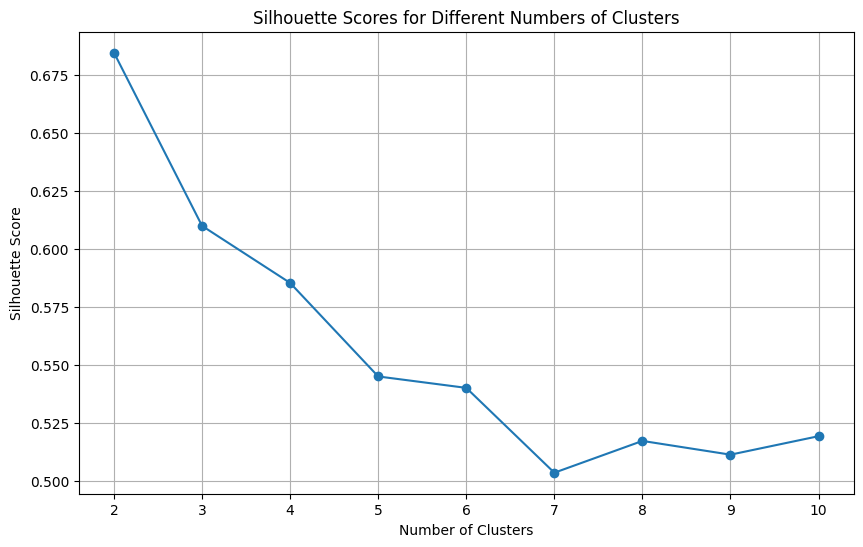

In [24]:
# determining optimal number of clusters with silhouette score
# plot shows 2 is most optimal regarding simplistic, actionable insights - but decided to go with 4 as it gives more detail and provides specified marketing strategies for different groups

silhouette_scores = []
range_n_clusters = range(2, 11)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(segmentation_data_scaled)
    silhouette_avg = silhouette_score(segmentation_data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# CLEAN DATA

In [ ]:
clean_data = df_final.drop(columns=['Revenue_Bucket', 'hour', 'day_of_week', 'time_of_day', 'User_Birthday', 'Number_of_Products', 'Country_Code'])

clean_data

clean_data.to_csv('/content/drive/My Drive/MiQ_Data/clean_data.csv', index=False)

,timestamp,Product_Name,Product_ID,Is_First_Order,User_Gender,Payment_Type,Order_Coupon_Code,City,Country_Province,User_ID,Order_ID,Revenue(AUD),Unique_Products,Total_Products
0,2017-10-17 23:51:00,Axel,TO057AC96EOH,0,female,cc@braintree,NaN,St Marys,NSW,1600610,235717632,0.06,1,1
1,2017-10-11 01:54:00,Nike Free Run Commuter 2017 Running Shoe - Wom...,NI126SF61QHM,0,female,pbi@afterpay,SPRING,Annandale,NSW,945013,226459232,0.07,1,1
2,2017-10-20 03:32:00,"Tallwood Sandals,Cuban","SP869SH19VQQ,BI358SH36RMH",0,female,paypal@braintree,NaN,North Narrabeen,NSW,1165125,283754932,0.10,2,2
3,2017-10-12 22:41:00,Dry Breathe Elastika Tank,NI126SA12VUT,0,female,paypal@braintree,NaN,Hove,SA,2473521,293521232,0.11,1,1
4,2017-10-12 08:28:00,Mid-Rise Compression Tights,2X445SA90ONX,0,female,cc@braintree,FLASH40,West Hoxton,NSW,649689,249295232,0.13,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102455,2017-10-16 00:58:00,"Aubrey Frill Top,Verona Shorts,Yasmine Tie Str...","CA787AA49QXI,PR105AA67IGM,AT049AA63CPO,MI570AA...",0,female,cc@braintree,SPRING,Eveleigh,NSW,47073,233266632,1641.34,21,42
102456,2017-10-02 06:45:00,"Lithium Cap Sleeve Dress,Sophia Mini Dress,Sag...","PI774AA89LQG,RO967AA10RLH,LI488AA35POI,FO605AA...",0,female,cc@braintree,NaN,Northbridge,NSW,2380025,226967312,1641.79,10,14
102457,2017-10-18 03:01:00,"Shapeshifter Shift Dress,One Shoulder Peplum D...","FA860AA43WRO,FA860AA57WRA,CA787AA31EDG,TU931AA...",0,female,paypal@braintree,NaN,Torrens Park,SA,464422,252125632,1642.59,7,7
102458,2017-10-03 07:25:00,"High And Mighty Jacket,Tre Shirt,Lugano 26mm,N...","LU900AA68YBF,PR692AA09TQG,LA033AC97DHM,LA033AC...",0,female,cc@braintree,NaN,Sydney,NSW,2204760,294655312,1643.33,7,7
